In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression

import eli5
from eli5.sklearn import PermutationImportance
import shap
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
train = pd.read_csv('train.csv')

In [8]:
target = train['target']
features = train.loc[:, "0":"299"]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,\
    shuffle=True, random_state=123)

In [19]:
logitModel = LogisticRegression(penalty='none').fit(x_train, y_train)

In [21]:
yhat = logitModel.predict(x_train)
print(accuracy_score(y_train, yhat))
print(roc_auc_score(y_train, yhat))
print(f1_score(y_train, yhat))

1.0
1.0
1.0


In [22]:
yhat = logitModel.predict(x_test)
print(accuracy_score(y_test, yhat))
print(roc_auc_score(y_test, yhat))
print(f1_score(y_test, yhat))

0.66
0.605263157894737
0.41379310344827586


In [24]:
logitModel = LogisticRegression(penalty='none').fit(x_train, y_train)
perm = PermutationImportance(logitModel).fit(x_train, y_train)

In [26]:
eli5.show_weights(perm, top=20)

Weight,Feature
0.0010 ± 0.0040,x127
0 ± 0.0000,x92
0 ± 0.0000,x108
0 ± 0.0000,x107
0 ± 0.0000,x106
0 ± 0.0000,x105
0 ± 0.0000,x104
0 ± 0.0000,x103
0 ± 0.0000,x102
0 ± 0.0000,x101


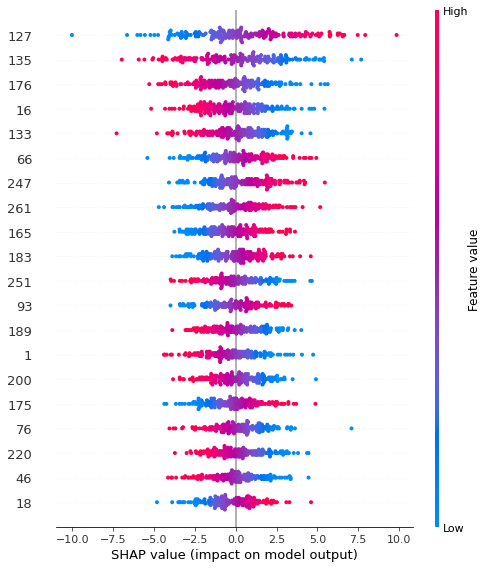

In [29]:
logitModel = LogisticRegression(penalty='none').fit(x_train, y_train)
explainer = shap.LinearExplainer(logitModel, masker=x_train)
shap_value = explainer.shap_values(x_train)
shap.summary_plot(shap_value, x_train)

In [31]:
logitModel = LogisticRegression(penalty='none').fit(x_train, y_train)
feature_selector = RFE(logitModel, n_features_to_select=20).fit(x_train, y_train)

In [37]:
x_train_selected = x_train.loc[:, feature_selector.support_]
x_test_selected = x_test.loc[:, feature_selector.support_]

In [38]:
logitModel = LogisticRegression(penalty='none').fit(x_train_selected, y_train)

In [39]:
yhat = logitModel.predict(x_test_selected)
print(roc_auc_score(y_test, yhat))

0.6469298245614035


In [46]:
svmModel = SVC(C=1, gamma=10).fit(x_train_selected, y_train)

In [41]:
yhat = svmModel.predict(x_train)
roc_auc_score(y_train, yhat)

1.0

In [47]:
yhat = svmModel.predict(x_test_selected)
roc_auc_score(y_test, yhat)

0.5

In [49]:
base_model = SVC(C=1, gamma=1)
score = cross_val_score(base_model, x_train, y_train, cv=10, scoring='accuracy')
print(score)
print(score.mean())

[0.7  0.7  0.7  0.7  0.7  0.75 0.75 0.75 0.75 0.75]
0.725


In [50]:
kfolds = KFold(n_splits=10, shuffle=True)
score = cross_val_score(base_model, x_train, y_train, cv=kfolds, scoring='accuracy')
print(score)
print(score.mean())

[0.65 0.85 0.65 0.65 0.7  0.95 0.6  0.8  0.75 0.65]
0.725


In [51]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(estimator=base_model, X=x_train, y=y_train, cv=folds, scoring='accuracy')
print(score)
print(score.mean())

[0.7  0.7  0.7  0.7  0.7  0.75 0.75 0.75 0.75 0.75]
0.725


In [53]:
base_model = SVC(C=1, gamma=1, kernel='linear')

In [55]:
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
cross_val_score(base_model, x_train, y_train, cv=folds, scoring='accuracy')
score

array([0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.75, 0.75, 0.75, 0.75, 0.75])

In [57]:
help(SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`~sklearn.svm.LinearSVC` or
 |  :class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 

In [59]:
model = SVC()

In [81]:
params = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly']
}

In [82]:
search = GridSearchCV(model, params, scoring='accuracy', cv=folds)

In [83]:
result = search.fit(x_train, y_train)

In [89]:
result.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [90]:
result.best_score_

0.725

In [86]:
best_model = result.best_estimator_

In [88]:
best_model

SVC(C=0.1, gamma=0.1)

In [120]:
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)

svmModel = SVC()
scores = cross_val_score(svmModel, x_train, y_train, cv=folds, scoring='roc_auc')
print(scores.mean())

0.6434857142857142


In [121]:
svmModel = SVC().fit(x_train, y_train)

In [122]:
perm = PermutationImportance(svmModel, random_state=123).fit(x_train, y_train)

In [123]:
eli5.show_weights(perm)

Weight,Feature
0.0080 ± 0.0049,x189
0.0080 ± 0.0080,x95
0.0070 ± 0.0049,x97
0.0060 ± 0.0040,x244
0.0060 ± 0.0133,x127
0.0060 ± 0.0075,x204
0.0050 ± 0.0000,x206
0.0050 ± 0.0000,x292
0.0050 ± 0.0063,x265
0.0040 ± 0.0075,x187


In [124]:
selected_columns = eli5.formatters.as_dataframe.explain_weights_df(perm)

In [125]:
selected_columns = selected_columns[selected_columns['weight'] != 0]

In [126]:
top_features = [i[1:] for i in selected_columns.feature if "BIAS" not in i]

In [127]:
x_train_selected = x_train[top_features]

In [128]:
svmModel = SVC()
scores = cross_val_score(svmModel, x_train_selected, y_train, cv=folds, scoring='roc_auc')

In [129]:
scores.mean()

0.8351142857142858

In [130]:
params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, 10, 100],
    "kernel": ['linear', 'rbf', 'sigmoid', 'poly']
}
search = GridSearchCV(svmModel, params, scoring='roc_auc', cv=folds)

In [131]:
results = search.fit(x_train_selected, y_train)

In [132]:
print(results.best_params_)
print(results.best_score_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.8405904761904762


In [133]:
x_test_selected = x_test[top_features]

In [134]:
best_model = results.best_estimator_
yhat = best_model.predict(x_test_selected)
print(roc_auc_score(y_test, yhat))

0.5


In [139]:
pipeline = Pipeline([
    ('로지스틱', LogisticRegression())
])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('로지스틱', LogisticRegression())])

In [140]:
yhat = pipeline.predict(x_test)

In [141]:
roc_auc_score(y_test, yhat)

0.6140350877192982

In [142]:
pipeline = Pipeline([
    ('스케', StandardScaler()),
    ('로지', LogisticRegression())
])

In [143]:
pipeline.fit(x_train, y_train)
yhat = pipeline.predict(x_test)
roc_auc_score(y_test, yhat)

0.6140350877192982

In [144]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logit', LogisticRegression())
])
folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc')
scores.mean()

0.6545454545454545

In [145]:
pipeline.fit(x_train, y_train)
yhat = pipeline.predict(x_test)
roc_auc_score(y_test, yhat)

0.6140350877192982

In [154]:
model = LogisticRegression(class_weight='balanced', solver='liblinear')

In [156]:
model = model.fit(x_train, y_train)

In [157]:
feature_selector = RFECV(model, min_features_to_select=20, cv=folds).fit(x_train, y_train)

In [158]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logit', LogisticRegression())
])
x_train_selected = x_train.loc[:, feature_selector.support_]
x_test_selected = x_test.loc[:, feature_selector.support_]

pipeline.fit(x_train_selected, y_train)
yhat = pipeline.predict(x_test_selected)
print(roc_auc_score(y_test, yhat))

0.5899122807017544


In [ ]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logit', LogisticRegression())
])
x_train_selected = x_train.loc[:, feature_selector.support_]
x_test_selected = x_test.loc[:, feature_selector.support_]

params = {
    'logit__penalty'
}
